# Optimism Retro Funding 5: Simulated Vote

In [1]:
from collections import defaultdict
import json
import pandas as pd
import numpy as np
import random
import secrets

In [2]:
# Round parameters (don't edit)
CATEGORIES = ['eth_core', 'op_tooling', 'op_rnd']
NUM_CATEGORIES = len(CATEGORIES)
MAX_BUDGET = 8_000_000
MIN_BUDGET = 2_000_000
BUDGET_INCREMENT = 50_000

NUM_VOTERS = 100
MAX_COI_PROJECTS = 5

MIN_CAP = 1_000
MAX_CAP_PCT = .125

PROXY_METRIC = 'num_trusted_stars'

# Load project data

In [3]:
apps = json.load(open("data/applications.json"))
df_status = pd.read_csv('data/approved_applications.csv', index_col=0)

df_metrics = pd.read_csv("data/rf5_applicant_github_metrics.csv")
impact_vals = df_metrics.groupby('application_id')[PROXY_METRIC].sum()
impact_vals = impact_vals / impact_vals.max()
impact_dict = impact_vals.to_dict()

projects_data = []
for app in apps:
    project = app.get('project', {})
    project_id = project.get('id')    
    project_name = project.get('name')
    
    status = df_status.loc[project_id, 'Final Status']
    if status != 'Approved':
        continue
    try:
        application_id = app['impactStatementAnswer'][0]['applicationId']
        category_id = app['impactStatementAnswer'][0]['impactStatement']['categoryId']                             
    except:
        print("No impact statement for:", project_name)
        continue

    projects_data.append({
        'project_id': project_id,
        'application_id': application_id,
        'project_name': project_name,
        'category_id': int(category_id),
        'impact': impact_dict.get(
            application_id,
            np.random.uniform(impact_vals.median(), 1)
        ),      
    })

No impact statement for: Formal Verification of Optimism's L1 pausability mechanism


In [4]:
# Initialize categories and projects

projects = {p['project_id']: p['impact'] for p in projects_data}

projects_by_category = defaultdict(list)
for p in projects_data:
    category = CATEGORIES[p['category_id']-1]
    projects_by_category[category].append(p['project_id'])

projects_by_category['op_tooling'][:5]

['0x66a3f6245dc3ac966d3ed9dd8c076a723cfc3aaaf5ea3721c634d46c3be46331',
 '0xf00518dc6abc147a7c46675cb76946afdd16868d7d4ab4689df0c48467158c26',
 '0x3787feef9d17b0d7db30c90fb419f1e8b0587a60bc3031fd9452b1ef1ab77680',
 '0x5742c7b3f7096fb9dd7a82cc62a4fda1e72aad9bdba9818c0d953fc82be9903d',
 '0xff3bed7d64f6f616e89032f8661f61259bc0b416ff39e1c8584ae8b34c48dbaa']

# Run voting simulation

<Axes: >

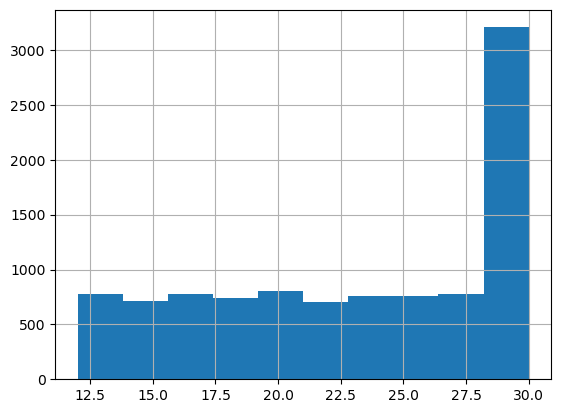

In [5]:
def randomize_project_allocation(impact_score):

    max_percent = 30
    min_percent = np.random.randint(0,2)
    random_val = np.random.uniform(.5,1.5)
    scaled_val = np.clip(impact_score * random_val * max_percent, a_max=max_percent, a_min=min_percent)
    return scaled_val


pd.Series([randomize_project_allocation(0.8) for _ in range(10_000)]).hist()

In [6]:
def randomize_budget():

    max_budget = MAX_BUDGET + MIN_BUDGET
    min_budget = 0
    random_val = 1/np.random.pareto(1.69)
    scaled_val = (random_val / (random_val + 1)) * (max_budget - min_budget) + min_budget
    round_val = int(round(scaled_val / BUDGET_INCREMENT) * BUDGET_INCREMENT)
    return min(max(round_val, MIN_BUDGET), MAX_BUDGET)

# Generate voter ballots
def generate_ballot():

    # Generate random category for the voter
    assigned_category = random.sample(CATEGORIES, 1)[0]

    # Generate random COI list for each voter (for simplicity, random projects)
    coi_projects = list(random.sample(list(projects.keys()), random.randint(0, MAX_COI_PROJECTS)))

    # Create a random threshold (up to 10%) for the voter to "zero" vote projects they don't like
    zero_thresh = random.randint(0, 1000)/100 

    # Determine total budget allocation
    total_budget = randomize_budget()
    
    #  Determine category allocations
    category_allocations = {category: random.randint(0, 10000)/100. for category in CATEGORIES}
    total = sum(category_allocations.values())
    category_allocations = {k: (v * 100 / total) for k, v in category_allocations.items()}

    # Determine project allocations within a category
    for category, proj_list in projects_by_category.items():
        if category != assigned_category:
            continue

        project_allocations = defaultdict(list)
        for project in proj_list:
            impact_seed = projects[project]
            alloc = randomize_project_allocation(impact_seed)
            if alloc < zero_thresh or project in coi_projects:
                alloc = 0
            project_allocations[project] = alloc
        
        total = sum(project_allocations.values())
        project_allocations = {
            k: v * 100 / total if k not in coi_projects else None
            for k, v in project_allocations.items()
        }

    return {
        "voter_id": f"0x{secrets.token_hex(20)}",
        "budget": total_budget,
        "category_assignment": assigned_category,
        "category_allocations": category_allocations,
        "project_allocations": project_allocations
    }

# Generate all voter ballots
synthetic_data = [generate_ballot() for _ in range(NUM_VOTERS)]

# Process the votes

In [7]:
# Step 0. Parse all the ballots (and remove null votes)
budget_votes = []
category_scores = defaultdict(list)
project_scores = defaultdict(lambda: defaultdict(list))
for ballot in synthetic_data:
    budget_votes.append(ballot['budget'])
    assigned_category = ballot['category_assignment']
    for category, category_percentage in ballot['category_allocations'].items():
        category_scores[category].append(category_percentage)

    for project, project_percentage in ballot['project_allocations'].items():
        if pd.isnull(project_percentage):
            continue
        project_scores[assigned_category][project].append(project_percentage)

# Step 1A. Calculate total funding for the round based on median budget vote
median_total_budget = np.median(budget_votes)
MAX_CAP = median_total_budget * MAX_CAP_PCT

# Step 1B. Calculate medians for categories and normalize to weights across categories
category_medians = {k: np.median(v)/100 for k, v in category_scores.items()}    
category_total = sum(category_medians.values())
category_weights = {k: v/category_total for k, v in category_medians.items()}

# Step 2. Calculate medians for projects and normalize to weights within a category
project_weights = defaultdict(lambda: defaultdict(list))
for category, project_dict in project_scores.items():
    for project, scores in project_dict.items():
        project_weights[category][project] = np.median(scores) / 100
    category_subtotal = sum(project_weights[category].values())
    for k, v in project_weights[category].items():
        project_weights[category][k] = v/category_subtotal 

# Step 3. Create an initial series of project funding allocations
initial_project_allocations = pd.Series()
for category, projects in project_weights.items():
    for project, score in projects.items():
        initial_project_allocations.loc[project] = score * category_weights[category] * median_total_budget

# Check the results makes sense
print(f"\nMedian Budget: {median_total_budget:,.0f}")
for c in CATEGORIES:
    print("\nCategory:", c)
    print("-----------------")
    print(f"Median Allocation: {category_weights[c]*100:.2f}%")
    print("Total Projects:", len(project_weights[c]))
    print(f"Check: Sum of Project Allocations Within Category: {sum(project_weights[c].values())*100:.1f}%\n")
print("******************")    
print(f"\nCheck: Sum of Project Allocations Across All Categories: {initial_project_allocations.sum():,.0f}")


Median Budget: 6,650,000

Category: eth_core
-----------------
Median Allocation: 31.65%
Total Projects: 33
Check: Sum of Project Allocations Within Category: 100.0%


Category: op_tooling
-----------------
Median Allocation: 33.99%
Total Projects: 25
Check: Sum of Project Allocations Within Category: 100.0%


Category: op_rnd
-----------------
Median Allocation: 34.36%
Total Projects: 20
Check: Sum of Project Allocations Within Category: 100.0%

******************

Check: Sum of Project Allocations Across All Categories: 6,650,000


Final Results:
 - Projects: 78
 - Voters: 100
 - Funding Available: 6650000.0
 - Funding Awarded: 6650000


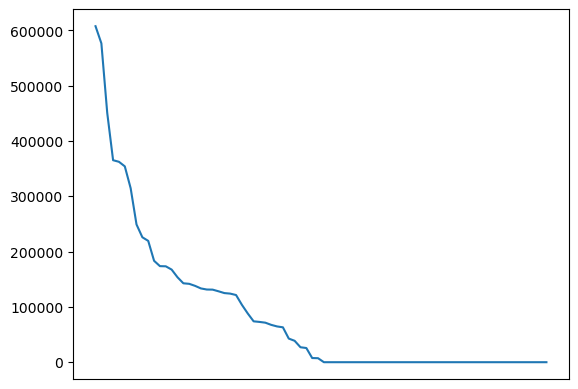

In [8]:
def allocate_funding(project_scores, funding_balance):
    """
    Helper for allocating and redistributing funding balances
    """
    score_balance = project_scores.sum()
    allocations = pd.Series()
    
    for project, score in project_scores.sort_values(ascending=False).items():
        uncapped_funding_alloc = score / score_balance * funding_balance
        capped_funding_alloc = min(uncapped_funding_alloc, MAX_CAP)
        allocations.loc[project] = capped_funding_alloc
        funding_balance -= capped_funding_alloc
        score_balance -= score

    return allocations


# Step 4. Implement max cap and redistribute excess
capped_allocations = allocate_funding(initial_project_allocations, median_total_budget)

# Step 5. Set the funding for projects below the minimum cap to 0
capped_allocations.loc[capped_allocations < MIN_CAP] = 0

# Step 6. Allocate the remaining funding to projects below the maximum cap
max_cap_funding = capped_allocations[capped_allocations == MAX_CAP].sum()
remaining_funding = median_total_budget - max_cap_funding
remaining_projects = capped_allocations[capped_allocations < MAX_CAP]
capped_allocations.update(allocate_funding(remaining_projects, funding_balance=remaining_funding))

# Check the results
capped_allocations.plot(xticks=[])
print("Final Results:")
print(" - Projects:", len(projects_data))
print(" - Voters:", NUM_VOTERS)
print(" - Funding Available:", median_total_budget)
print(" - Funding Awarded:", round(capped_allocations.sum()))

In [9]:
df_results = (
    pd.DataFrame(projects_data)
    .set_index('project_id')
    .join(
        pd.Series(capped_allocations, name='simulated_result')
    )
    .sort_values(by='simulated_result')
)
df_results.tail(20)

,application_id,project_name,category_id,impact,simulated_result
project_id,,,,,
0xe15a32ba713cc025574ac6f69be3ad16133fb7561c3d7dc30fbf29b65b5a8be2,85dd5d93-d1b6-47d0-ac10-012618d999cf,Erigon,1,0.590909,131443.445937
0x1ea2fc7183a8ad244a97ecc287ca922209274c11dd9e991a04315e8399e118fc,12ee508a-38e2-499d-a932-87a22c85be72,Asterisc,2,0.284091,133416.987503
0x7e4eb6294ad8e97eceb3bb6a39891eb386bfbaa5d4e8f16a9939d18ad79d789c,01577a0e-416a-4fbb-82d7-5dfbe3cabe25,Blocknative Blob Archive and Research,1,0.632021,138078.648293
0x7f1256b007e1156494e43b58d5e85e6ec20f4fcf1e5cac6ebb17b702e9c0b5fb,c043c493-62a9-453b-a599-87c8ae223e22,OP Nethermind,1,0.723967,141750.056976
0xcc8d03e014e121d10602eeff729b755d5dc6a317df0d6302c8a9d3b5424aaba8,1732e47f-c6fa-4ab2-b116-18d33347c3e9,Solidity,1,0.590909,142721.985203
0x8e05097e0cd6d79100e77cc5f8efe1b405633ee56c79f54ce657eaa58d3c995c,a298b502-d3c5-4dde-bbd6-a190c3f7b487,Zeeve RaaS for OP Stack,3,0.207161,153609.808123
0x5759249c433d67eeb2ca1b6ff827feec164b60b92e849d6ce0db0974cedc4a89,dd8d7a7e-5f95-4523-8f6d-c3a64ee7754b,OP Reth,1,0.784091,167488.528064
0x79c2ae8858a5a3bd7f2e0da9509d727833ffa01f358b5969355f38ff32b20122,06bceb66-8644-4704-8a73-e1b3feb328cf,go-ethereum,1,1.000000,173429.030472
0xe2f742ea351ea741e95f8cf4b2434317d8365c532b97601e8a27854003c2e396,64b4ff9a-f7cf-452d-8932-d0a5f29a828a,Code4rena,2,0.324387,173731.395659
